# Overview

1. Project Instructions & Prerequisites
2. Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

# 2. Objectives

   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels (longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
import warnings
warnings.filterwarnings('ignore')

# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
# Place helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Response: The total number of rows exceeds the total number of unique encoutners (143424 > 101766), indicating that the dataset is at the line level. We can aggregate on the *encounter_id* and *patient_nbr*, and possibly also the *primary_diagnosis_code*.

In [4]:
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143419,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,38,590|296,1,0,0,53,13,9,0,47918-902,None,None,Ch,NO
143420,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0049-4110,None,None,Ch,NO
143421,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0781-5421,None,None,Ch,NO
143422,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,47918-902,None,None,Ch,NO


In [5]:
total_rows = len(df)
total_unique_encounters = df['encounter_id'].nunique()

if total_rows > total_unique_encounters:
    print(f"Total rows exceeds total unique encounters: {total_rows} > {total_unique_encounters}")
    print("Dataset is at the line level.")

Total rows exceeds total unique encounters: 143424 > 101766
Dataset is at the line level.


## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Response**:

##### A) Missing Values
Field(s) with high amount of missing/zero values

In [106]:
print("Dataset containts two types of data: integer data and non-integer data: ")
set(df.dtypes.tolist())

Dataset containts two types of data: integer data and non-integer data: 


{dtype('int64'), dtype('O')}

First, identify invalid or unknown values in non-integer data.

As a sample case, consider 'weight':

In [96]:
print(len(df['weight']))
invalid_weight = df['weight'][df['weight'].str.contains('\?|Unknown/Invalid', na=True)]
valid_weight = df['weight'][~df['weight'].str.contains('\?|Unknown/Invalid', na=True)]
print(f"Weight:\nNumber invalid={len(invalid_weight)}\nNumber valid={len(valid_weight)}\nTotal={len(invalid_weight) + len(valid_weight)}")
print("Weight field is mostly invalid!")

143424
Weight:
Number invalid=139122
Number valid=4302
Total=143424
Weight field is mostly invalid!


Another example case: 'other_diagnosis_codes':

In [97]:
missing_vals = ['?', 'Unknown/Invalid'] + df['other_diagnosis_codes'][df['other_diagnosis_codes'].str.contains('\?', na=True)].unique().tolist()

print(len(df['other_diagnosis_codes'][df['other_diagnosis_codes'].str.contains('\?|Unknown/Invalid', na=True)].unique().tolist()))

195


Now check the remaining columns:

In [98]:
missing_vals = ['?', 'Unknown/Invalid']

for colname in df.select_dtypes(include=['object']).columns:
    invalid_count = len(df[colname][df[colname].str.contains('\?|Unknown/Invalid', na=True)])
    percent_invalid = invalid_count / len(df[colname]) * 100
    print(f"{colname}: {invalid_count}, {percent_invalid:.2f}")

# df.select_dtypes(include=['object'])[df.select_dtypes(include=['object'])].str.contains(missing_vals).nunique()

race: 3309, 2.31
gender: 5, 0.00
age: 0, 0.00
weight: 139122, 97.00
payer_code: 54190, 37.78
medical_specialty: 69463, 48.43
primary_diagnosis_code: 33, 0.02
other_diagnosis_codes: 1984, 1.38
ndc_code: 23462, 16.36
max_glu_serum: 0, 0.00
A1Cresult: 0, 0.00
change: 0, 0.00
readmitted: 0, 0.00
generic_drug_name: 23462, 16.36


We can conclude that **'weight'**, **'payer_code'**, and **'medical_specialty'** have a high percentage (>35%) missing values, so we will choose not to include these fields in the regression model training.

In [8]:
# First look at integer fields

df.select_dtypes(include=['int64']).columns.tolist()

['encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures']

Next, we examine integer columns. When checking for zero values, it is first necessary to check if a value of zero could actually be valid, for example zero visits to the emergency room.

In [99]:
# First check which fields contain 0:

print("Integer columns containing zero: ")
for val in df.select_dtypes(include=['int64']).columns.tolist():
    options = df[val].unique()
    if 0 in options:
        print(f"{val} includes 0:\n {options}\n")

Integer columns containing zero: 
number_outpatient includes 0:
 [ 0  2  1  5  7  9  3  8  4 12 11  6 20 15 10 13 14 16 21 35 17 29 36 18
 19 27 22 24 42 39 34 26 33 25 23 28 37 38 40]

number_inpatient includes 0:
 [ 0  1  2  3  6  5  4  7  8  9 15 10 11 14 12 13 17 16 21 18 19]

number_emergency includes 0:
 [ 0  1  2  4  3  9  5  7  6  8 22 25 10 13 42 16 11 28 15 14 18 12 21 20
 19 46 76 37 64 63 54 24 29]

num_procedures includes 0:
 [0 5 1 6 2 3 4]



In [100]:
# Zeros in these columns are not necessarily missing values:
cols_valid_zeros = ['number_outpatient', 'number_inpatient', 'number_emergency', 'num_procedures']

In [101]:
df.select_dtypes(include=['int64'])[(df.select_dtypes(include=['int64']) == 0).notna()]

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
0,2278392,8222157,6,25,1,1,0,0,0,41,1,1,0
1,149190,55629189,1,1,7,3,0,0,0,59,9,18,0
2,64410,86047875,1,1,7,2,2,1,0,11,6,13,5
3,500364,82442376,1,1,7,2,0,0,0,44,7,16,1
4,16680,42519267,1,1,7,1,0,0,0,51,5,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
143419,443854148,41088789,1,1,7,1,1,0,0,53,13,9,0
143420,443857166,31693671,2,3,7,10,0,1,0,45,9,21,2
143421,443857166,31693671,2,3,7,10,0,1,0,45,9,21,2
143422,443857166,31693671,2,3,7,10,0,1,0,45,9,21,2


In [13]:
(~df.select_dtypes(include=['int64']).astype(bool)).sum(axis=0)

encounter_id                     0
patient_nbr                      0
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
number_outpatient           120027
number_inpatient             96698
number_emergency            127444
num_lab_procedures               0
number_diagnoses                 0
num_medications                  0
num_procedures               65788
dtype: int64

We only see 0 in the columns 'number_outpatient', 'number_inpatient', 'number_emergency', and 'num_procedures', and zeros in these columns are probably valid based on patient context. For example, in our dataset not every patient is expected to go to the emergency room.

##### B) Numerical Field distributions
Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?

In [14]:
df.select_dtypes(include=['int64'])

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
0,2278392,8222157,6,25,1,1,0,0,0,41,1,1,0
1,149190,55629189,1,1,7,3,0,0,0,59,9,18,0
2,64410,86047875,1,1,7,2,2,1,0,11,6,13,5
3,500364,82442376,1,1,7,2,0,0,0,44,7,16,1
4,16680,42519267,1,1,7,1,0,0,0,51,5,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
143419,443854148,41088789,1,1,7,1,1,0,0,53,13,9,0
143420,443857166,31693671,2,3,7,10,0,1,0,45,9,21,2
143421,443857166,31693671,2,3,7,10,0,1,0,45,9,21,2
143422,443857166,31693671,2,3,7,10,0,1,0,45,9,21,2


Show histogram plots:

encounter_id


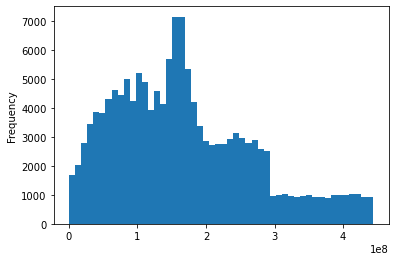

patient_nbr


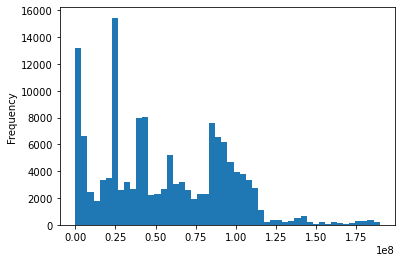

admission_type_id


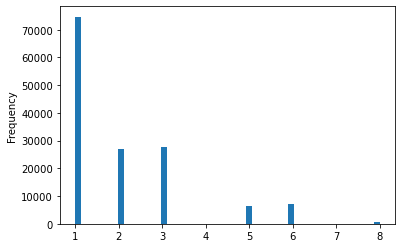

discharge_disposition_id


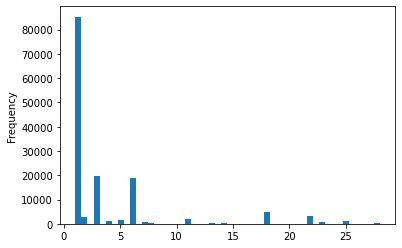

admission_source_id


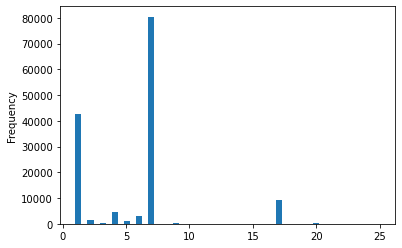

time_in_hospital


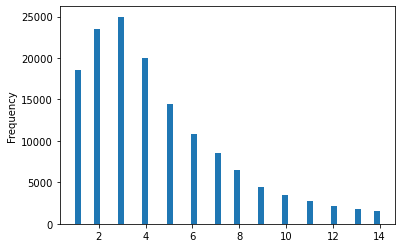

number_outpatient


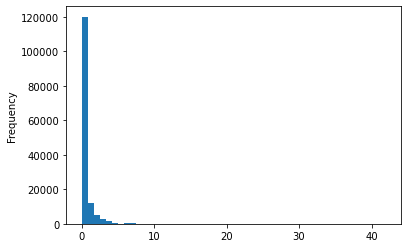

number_inpatient


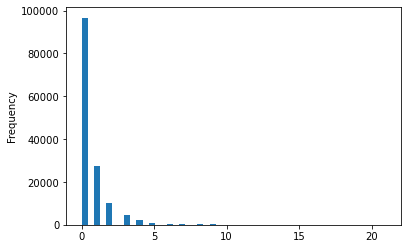

number_emergency


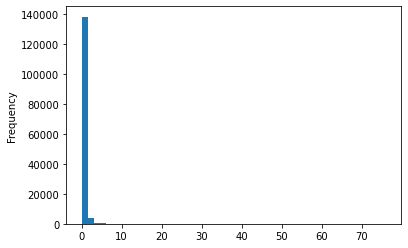

num_lab_procedures


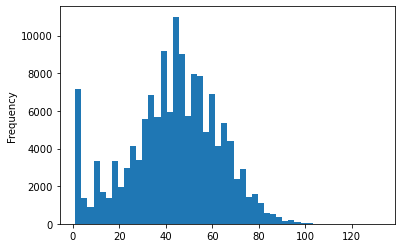

number_diagnoses


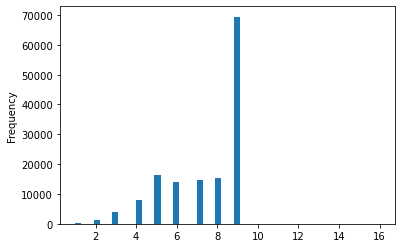

num_medications


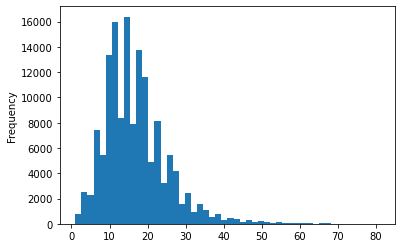

num_procedures


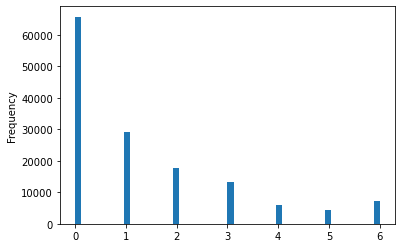

In [15]:
for colname in df.select_dtypes(include=['int64']).columns:
    print(colname)
    df.select_dtypes(include=['int64'])[colname].plot.hist(bins=50)
    plt.show()

As found in the previous section, the weight column has mostly missing data:


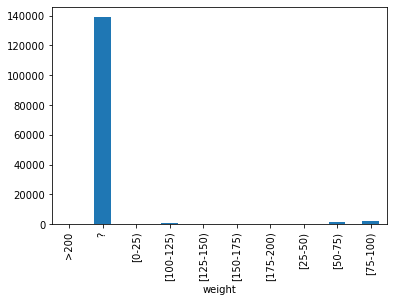

Age is left-skewed:


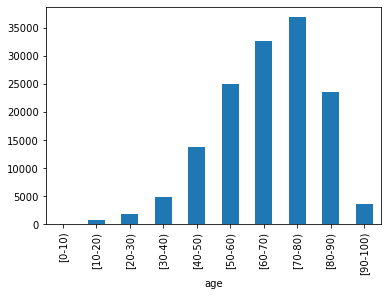

In [104]:
# Some non-integer columns actually represent numeric data that may have a Gaussian distribution:

print("As found in the previous section, the weight column has mostly missing data:")
display(df.groupby('weight').size().plot(kind='bar'))
plt.show()

print("Age is left-skewed:")
display(df.groupby('age').size().plot(kind='bar'))
plt.show()

Gaussian distributions:
- time_in_hospital (right-skewed)
- num_lab_procedures
- num_medications (right-skewed)
- age (left-skewed)

'weight' is not a Gaussian distribution because there are too many invalid values ('?').

##### C) High Cardinality
 Which field(s) have high cardinality and why (HINT: ndc_code is one feature)

In [17]:
set(df.dtypes.tolist())

{dtype('int64'), dtype('O')}

In [18]:
df.select_dtypes(include=['object']).nunique()

race                          6
gender                        3
age                          10
weight                       10
payer_code                   18
medical_specialty            73
primary_diagnosis_code      717
other_diagnosis_codes     19374
ndc_code                    251
max_glu_serum                 4
A1Cresult                     4
change                        2
readmitted                    3
dtype: int64

In [109]:
high_cardinality_threshold = 25
print("Columns with high cardinality: ")
display(df.select_dtypes(include=['object']).nunique()[df.select_dtypes(include=['object']).nunique() > high_cardinality_threshold])

print("Note that Age and Weight columns have already been binned, reducing dimensionality.")

Columns with high cardinality: 


medical_specialty            73
primary_diagnosis_code      717
other_diagnosis_codes     19374
ndc_code                    251
dtype: int64

Note that Age and Weight columns have already been binned, reducing dimensionality.


**'Primary_diagnosis_code'**, **'other_diagnosis_codes'**, **'ndc_code'**, and medical_specialty have high cardinality. These are not surprising due to the high number of available codes and specialties.

In [20]:
# !pip install apache-beam[interactive]

In [21]:
# import tensorflow_data_validation as tfdv

# ######NOTE: The visualization will only display in Chrome browser. ########
# full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
# tfdv.visualize_statistics(full_data_stats)

##### D) Age and Gender Demographics

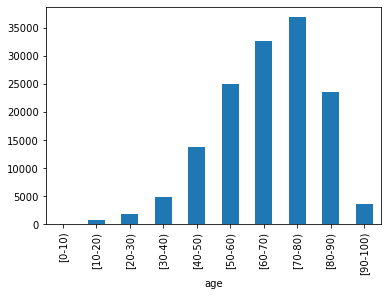

In [22]:
df.groupby('age').size().plot(kind='bar')

In [110]:
# Only a few values are unknown:
df['gender'][df['gender'] == 'Unknown/Invalid']

40909     Unknown/Invalid
40910     Unknown/Invalid
105847    Unknown/Invalid
116160    Unknown/Invalid
116161    Unknown/Invalid
Name: gender, dtype: object

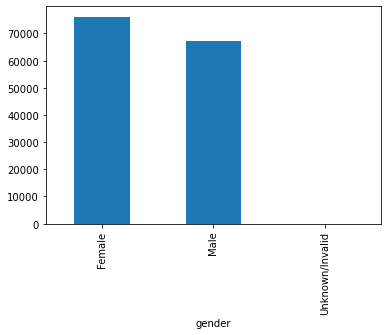

In [24]:
df.groupby('gender').size().plot(kind='bar')

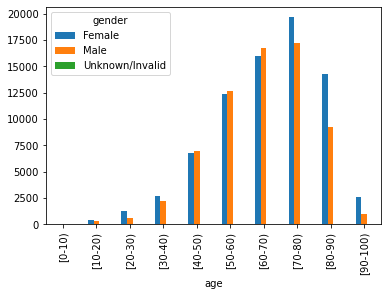

In [25]:
gender_column = 'gender'
df.groupby(["age", gender_column]).size().unstack(level=1).plot(kind='bar')

**Age** follows a left-skewed Gaussian distribution, while **Gender** is roughly equal counts Male and Female for all age bins except \[80-90) and \[90-100), where females outnumber males significantly. Females tend to live longer than men, so this is likely representative of the broader population.

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [26]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [27]:
ndc_code_df

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
...,...,...,...,...,...,...,...
264,0781-5635,Pioglitazone Hydrochloride And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Tablet,Oral,Sandoz Inc,Human Prescription Drug
265,64764-302,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
266,64764-304,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
267,66993-821,Pioglitazone And Glimepiride,Pioglitazone And Glimepiride,Tablet,Oral,Prasco Laboratories,Human Prescription Drug


In [28]:
ndc_code_df['NDC_Code'].nunique()

267

In [29]:
from student_utils import reduce_dimension_ndc

In [30]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)
reduce_dim_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143419,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,38,590|296,1,0,0,53,13,9,0,47918-902,None,None,Ch,NO,Insulin Human
143420,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0049-4110,None,None,Ch,NO,Glipizide
143421,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0781-5421,None,None,Ch,NO,Pioglitazone
143422,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,47918-902,None,None,Ch,NO,Insulin Human


In [111]:
# Number of unique values should be less for the new output field
print(f"{df['ndc_code'].nunique()} > {reduce_dim_df['generic_drug_name'].nunique()}")
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()
print("Tests passed!!")

251 > 22
Tests passed!!


Note: Dimensionality could likely be reduced slightly further still, for instance Human Insulin and Insulin Human may refer to the same generic drug.

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [32]:
reduce_dim_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143419,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,38,590|296,1,0,0,53,13,9,0,47918-902,None,None,Ch,NO,Insulin Human
143420,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0049-4110,None,None,Ch,NO,Glipizide
143421,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0781-5421,None,None,Ch,NO,Pioglitazone
143422,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,47918-902,None,None,Ch,NO,Insulin Human


In [33]:
reduce_dim_df.sort_values(by=['encounter_id'])

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
12,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,Insulin Human
11,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,0049-4110,None,None,Ch,NO,Glipizide
14,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Human Insulin
13,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,0173-0863,None,None,Ch,NO,Rosiglitazone Maleate
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143418,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,38,590|296,1,0,0,53,13,9,0,10631-019,None,None,Ch,NO,Metformin Hydrochloride
143421,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0781-5421,None,None,Ch,NO,Pioglitazone
143422,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,47918-902,None,None,Ch,NO,Insulin Human
143420,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0049-4110,None,None,Ch,NO,Glipizide


In [34]:
reduce_dim_df.sort_values(by=['encounter_id']).drop_duplicates(subset="patient_nbr")

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
12,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,Insulin Human
14,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide
15,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,Human Insulin
6,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,Insulin Human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143405,443842016,183087545,Caucasian,Female,[70-80),?,1,1,7,9,?,?,574,574|250.02,0,0,0,50,9,33,2,0009-3449,None,>7,Ch,>30,Glyburide
143407,443842022,188574944,Other,Female,[40-50),?,1,1,7,14,MD,?,592,599|518,0,0,1,73,9,26,6,0049-0178,None,>8,Ch,>30,Glipizide
143409,443842070,140199494,Other,Female,[60-70),?,1,1,7,2,MD,?,996,585|403,1,1,1,46,9,17,6,47918-902,None,None,No,>30,Insulin Human
143411,443842340,120975314,Caucasian,Female,[80-90),?,1,1,7,5,MC,?,292,8|304,0,0,1,76,9,22,1,47918-902,None,None,Ch,NO,Insulin Human


In [35]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [36]:
first_encounter_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
12,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,Insulin Human
14,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide
15,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,Human Insulin
6,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,Insulin Human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143405,443842016,183087545,Caucasian,Female,[70-80),?,1,1,7,9,?,?,574,574|250.02,0,0,0,50,9,33,2,0009-3449,None,>7,Ch,>30,Glyburide
143407,443842022,188574944,Other,Female,[40-50),?,1,1,7,14,MD,?,592,599|518,0,0,1,73,9,26,6,0049-0178,None,>8,Ch,>30,Glipizide
143409,443842070,140199494,Other,Female,[60-70),?,1,1,7,2,MD,?,996,585|403,1,1,1,46,9,17,6,47918-902,None,None,No,>30,Insulin Human
143411,443842340,120975314,Caucasian,Female,[80-90),?,1,1,7,5,MC,?,292,8|304,0,0,1,76,9,22,1,47918-902,None,None,Ch,NO,Insulin Human


In [37]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [38]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

In [39]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [40]:
ndc_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide']

In [41]:
agg_drug_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54266,443841992,184875899,Other,Male,[40-50),?,1,1,7,13,?,?,250.8,730|731,0,0,0,51,9,13,2,0904-6328,None,None,Ch,NO,[Metformin Hydrochloride],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
54267,443842016,183087545,Caucasian,Female,[70-80),?,1,1,7,9,?,?,574,574|250.02,0,0,0,50,9,33,2,0009-3449,None,>7,Ch,>30,[Glyburide],0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54268,443842022,188574944,Other,Female,[40-50),?,1,1,7,14,MD,?,592,599|518,0,0,1,73,9,26,6,0049-0178,None,>8,Ch,>30,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54269,443842070,140199494,Other,Female,[60-70),?,1,1,7,2,MD,?,996,585|403,1,1,1,46,9,17,6,47918-902,None,None,No,>30,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Response:

**Excluded Fields**

The **'payer_code'** and **'weight'** fields should be excluded, because both contain a high number of unknown values. As shown in the plots below and evaluated in the *Missing Values* section above, the 'weight' field is **97%** missing values (data is '?') and the 'payer_code' field is **37.8%** missing values (data is '?'). Also, according to the project data schema, 'payer_code' represents data for the insurance or payment used, for example "Blue Cross\Blue Shield, Medicare, and self-pay".  While there could theoretically be a correlation between the insurance company or payment used and the length of a hospital stay, it doesn't seem worthwhile to include this value in the model since it does not directly relate to the medicine.

I also excluded **'encounter_id'** and **'patient_nbr'** because they are simply arbitrary unique identifiers for the encounter and patient data and would not meaningfully support model predictions. I excluded **'medical_specialty'** since it contained a high number of missing values, **48.43%**.

**Included Fields**

In addition to the required demographics fields (race, gender, age) and the NDC codes (indicating prescribed drugs and reduced to generic drug name), I chose to include the following fields, which have negligable or no missing information and seem likely to hold relevant data:
- Diagnosis Information: codes categorize medical diagnosis using the standardized ICD9 - CM code set.
 - **'primary_diagnosis_code'**
 - **'other_diagnosis_code'**
 - **'number_diagnoses'**: as plotted above, mode is clearly 9 however there is enough spread in the data that this could be a relevant field
- Relevant diabetes tests:
 - **'max_glu_serum'**
 - **'A1Cresult'**
- **'change'**: indicates change in diabetic medications
- **'readmitted'**: relevant to hospital stay duration
- **'num_medications'**: simple count of medications could correlate to longer hospital stay duration and is a Gaussian distribution (plotted above), which could indicate effective sampling of this value.

I did not include additional fields in order to reduce the cardinality of the input data, and I expect the fields above to carry meaningful data for the model to train on and ultimately correlate to hospital stay duration.

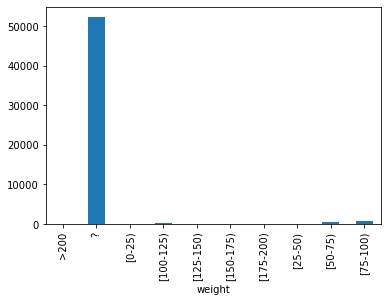

In [42]:
display(agg_drug_df.groupby('weight').size().plot(kind='bar'))
plt.show()

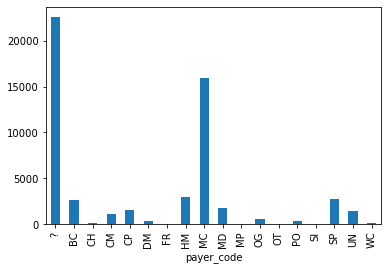

In [43]:
display(agg_drug_df.groupby('payer_code').size().plot(kind='bar'))
plt.show()

In [44]:
# List options for categorical features:
agg_drug_df.select_dtypes(include=['object']).columns.tolist()

['race',
 'gender',
 'age',
 'weight',
 'payer_code',
 'medical_specialty',
 'primary_diagnosis_code',
 'other_diagnosis_codes',
 'ndc_code',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'readmitted',
 'generic_drug_name_array']

In [45]:
# List options for numerical features:
agg_drug_df.select_dtypes(include=['int64']).columns.tolist()

['encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures']

In [112]:
print(ndc_col_list)

['Acarbose', 'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hcl', 'Glipizide_And_Metformin_Hydrochloride', 'Glyburide', 'Glyburide_And_Metformin_Hydrochloride', 'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human', 'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide', 'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride', 'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide']


In [46]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
# required_demo_col_list = ['race', 'gender', 'age']
# student_categorical_col_list = [ "feature_A", "feature_B", .... ] + required_demo_col_list + ndc_col_list
# student_numerical_col_list = [ "feature_A", "feature_B", .... ]
# PREDICTOR_FIELD = ''

required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = [ "primary_diagnosis_code", "other_diagnosis_codes", "max_glu_serum", "A1Cresult", "change", "readmitted"] + required_demo_col_list + ndc_col_list
student_numerical_col_list = [ "number_diagnoses", "num_medications" ]
PREDICTOR_FIELD = 'time_in_hospital'

In [47]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [48]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

In [49]:
selected_features_df

,patient_nbr,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,max_glu_serum,A1Cresult,change,readmitted,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,number_diagnoses,num_medications
0,48330783,13,398,427|38,None,None,Ch,NO,Caucasian,Female,[80-90),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,28
1,63555939,12,434,198|486,None,None,Ch,NO,Caucasian,Female,[90-100),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8,18
2,42519267,1,197,157|250,None,None,Ch,NO,Caucasian,Male,[40-50),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,8
3,89869032,9,250.7,403|996,None,None,No,>30,AfricanAmerican,Female,[40-50),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,9,17
4,82637451,3,414,411|250,None,None,No,>30,Caucasian,Male,[50-60),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,9,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54266,184875899,13,250.8,730|731,None,None,Ch,NO,Other,Male,[40-50),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,9,13
54267,183087545,9,574,574|250.02,None,>7,Ch,>30,Caucasian,Female,[70-80),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,33
54268,188574944,14,592,599|518,None,>8,Ch,>30,Other,Female,[40-50),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,26
54269,140199494,2,996,585|403,None,None,No,>30,Other,Female,[60-70),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,9,17


### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features.

In [50]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

In [51]:
processed_df

,patient_nbr,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,max_glu_serum,A1Cresult,change,readmitted,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,number_diagnoses,num_medications
0,48330783,13.0,398,427|38,None,None,Ch,NO,Caucasian,Female,[80-90),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,28
1,63555939,12.0,434,198|486,None,None,Ch,NO,Caucasian,Female,[90-100),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8,18
2,42519267,1.0,197,157|250,None,None,Ch,NO,Caucasian,Male,[40-50),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,8
3,89869032,9.0,250.7,403|996,None,None,No,>30,AfricanAmerican,Female,[40-50),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,9,17
4,82637451,3.0,414,411|250,None,None,No,>30,Caucasian,Male,[50-60),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,9,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54266,184875899,13.0,250.8,730|731,None,None,Ch,NO,Other,Male,[40-50),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,9,13
54267,183087545,9.0,574,574|250.02,None,>7,Ch,>30,Caucasian,Female,[70-80),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,33
54268,188574944,14.0,592,599|518,None,>8,Ch,>30,Other,Female,[40-50),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,26
54269,140199494,2.0,996,585|403,None,None,No,>30,Other,Female,[60-70),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,9,17


## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [53]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [54]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [55]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


In [56]:
train_list = d_train['patient_nbr'].to_list()
validate_list = d_val['patient_nbr'].to_list()
test_list = d_test['patient_nbr'].to_list()

assert set(train_list).isdisjoint(validate_list)
assert set(validate_list).isdisjoint(test_list)
print("Partitions are disjoint; no patient_nbr is found in multiple partitions.")

Partitions are disjoint; no patient_nbr is found in multiple partitions.


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

**Yes**, histogram distribution shapes are highly similar across partitions:

time_in_hospital
1.0     7318
2.0     9191
3.0     9740
4.0     7417
5.0     5348
6.0     3991
7.0     3123
8.0     2311
9.0     1597
10.0    1241
11.0    1008
12.0     783
13.0     663
14.0     540
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


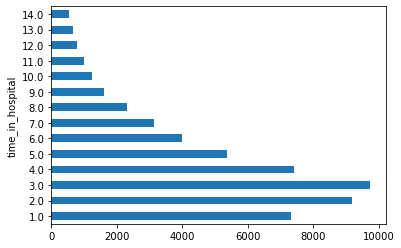

In [57]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     4425
2.0     5473
3.0     5892
4.0     4452
5.0     3223
6.0     2417
7.0     1790
8.0     1398
9.0      980
10.0     728
11.0     618
12.0     457
13.0     391
14.0     318
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


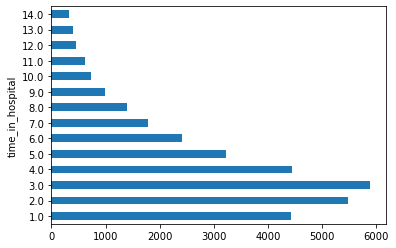

In [58]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     1478
2.0     1819
3.0     1926
4.0     1454
5.0     1090
6.0      791
7.0      718
8.0      460
9.0      281
10.0     243
11.0     181
12.0     173
13.0     128
14.0     113
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


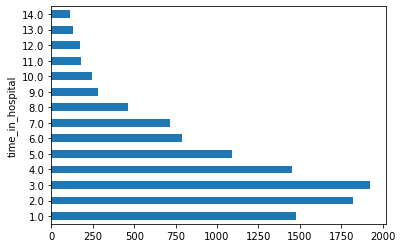

In [59]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             28572
Male               25697
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


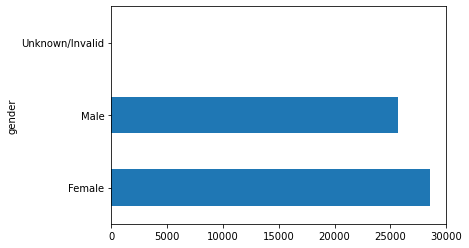

In [60]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             17107
Male               15454
Unknown/Invalid        1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


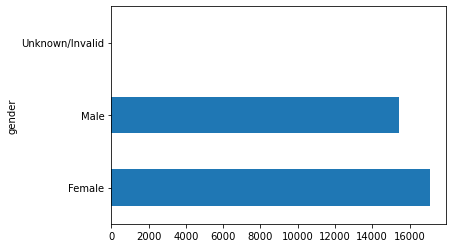

In [61]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    5708
Male      5147
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


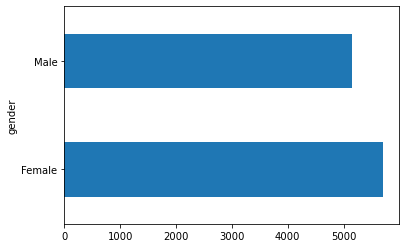

In [62]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [63]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [64]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [65]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [66]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 608 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 9445 in other_diagnosis_codes is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/other_diagnosis_codes_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in max_glu_serum is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/max_glu_serum_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in A1Cresult is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/A1Cresult_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/change_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in ra

In [67]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
EmbeddingColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_vocab.txt', vocabulary_size=608, num_oov_buckets=1, dtype=tf.string, default_value=-1), dimension=20, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f3506ec7c50>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)
tf.Tensor(
[[ 0.0959501  -0.12344719 -0.20842493 ...  0.26607007 -0.0269857
   0.2398782 ]
 [ 0.08652315  0.38892135  0.1736927  ... -0.20719038 -0.00308915
   0.01071642]
 [-0.20158759 -0.05992806 -0.32831392 ...  0.03823734  0.19239625
  -0.05578064]
 ...
 [ 0.4121899  -0.04359384 -0.24811032 ... -0.24260762  0.3437558
   0.11977646]
 [ 0.11509563  0.13368228  0.2624971  ... -0.44707346 -0.04369386
   0.3343911 ]
 [-0.17743944 -0.06986237  0.03900454 ...  0.01939535 -0.35058388
  -0.3646171 ]], shape=(128, 20), dtype=float32

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [68]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [69]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [70]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [71]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='number_diagnoses', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=<function create_tf_numeric_feature.<locals>.<lambda> at 0x7f34f7d515f0>)

tf.Tensor(
[[-1. ]
 [ 1. ]
 [-1. ]
 [ 0. ]
 [ 0.5]
 [-1. ]
 [-0.5]
 [ 1. ]
 [ 1. ]
 [ 0. ]
 [ 0.5]
 [ 0. ]
 [ 0.5]
 [-2.5]
 [ 0.5]
 [-1. ]
 [ 0. ]
 [ 1. ]
 [ 0.5]
 [-0.5]
 [ 1. ]
 [ 1. ]
 [ 0.5]
 [ 1. ]
 [-1. ]
 [-1. ]
 [ 1. ]
 [ 1. ]
 [-0.5]
 [-1. ]
 [-0.5]
 [-1. ]
 [ 1. ]
 [-1. ]
 [ 1. ]
 [ 0.5]
 [ 0. ]
 [-1. ]
 [-1.5]
 [-1. ]
 [ 1. ]
 [-0.5]
 [ 1. ]
 [ 1. ]
 [ 0. ]
 [ 0. ]
 [-2.5]
 [ 1. ]
 [ 1. ]
 [ 1. ]
 [ 0. ]
 [ 1. ]
 [ 0.5]
 [-2. ]
 [-1.5]
 [ 1. ]
 [ 1. ]
 [ 1. ]
 [-1. ]
 [-0.5]
 [-0.5]
 [ 1. ]
 [ 1. ]
 [ 0.5]
 [ 1. ]
 [ 0.5]
 [ 1. ]
 [-2.5]
 [ 0.5]
 [-0.5]
 [ 1. ]
 [ 0. ]
 [-0.5]
 [ 1. ]
 [-0.5]
 [-2. ]
 [ 1. ]
 [ 1. ]
 [-0.5]
 [ 0. ]
 [-0.5]
 [ 0.5]
 [-1.5]
 [ 1. ]
 [-1. ]
 [ 0. ]
 [ 0. ]
 [ 1. ]
 [-1. ]
 [-0.5]
 [ 1. ]
 [ 1. ]
 [-0.5]
 [ 0. ]
 [-0.5]
 [ 1. ]
 [ 1. ]
 [-0.5]
 [

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [72]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

In [73]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [74]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=30)

Train for 255 steps, validate for 85 steps
Epoch 1/30
255/255 [==============================] - 27s 106ms/step - loss: 28.9883 - mse: 28.9214 - val_loss: 25.5435 - val_mse: 25.3244
Epoch 2/30
255/255 [==============================] - 17s 66ms/step - loss: 19.1552 - mse: 18.5179 - val_loss: 19.1900 - val_mse: 18.7142
Epoch 3/30
255/255 [==============================] - 16s 63ms/step - loss: 16.1200 - mse: 15.2897 - val_loss: 13.7291 - val_mse: 12.5208
Epoch 4/30
255/255 [==============================] - 16s 63ms/step - loss: 13.4888 - mse: 12.5505 - val_loss: 13.1846 - val_mse: 12.5764
Epoch 5/30
255/255 [==============================] - 16s 64ms/step - loss: 12.5871 - mse: 11.5534 - val_loss: 12.3766 - val_mse: 11.4836
Epoch 6/30
255/255 [==============================] - 16s 63ms/step - loss: 11.2417 - mse: 10.4403 - val_loss: 10.8816 - val_mse: 9.7674
Epoch 7/30
255/255 [==============================] - 16s 63ms/step - loss: 10.7491 - mse: 9.6663 - val_loss: 11.5478 - val_mse: 

After 30 epochs, our model's validation loss reaches ~9, validation MSE reaches ~8.5.

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [75]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [76]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [77]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [113]:
prob_output_df.head(10)

,pred,actual_value,pred_mean,pred_std
0,10.921973,5.0,4.759126,0.691209
1,3.156476,4.0,3.019145,0.691668
2,4.227289,4.0,3.245703,0.693708
3,6.312609,2.0,0.893802,0.696285
4,3.678492,8.0,7.083068,0.690235
5,2.001064,2.0,1.512202,0.694214
6,2.980047,1.0,1.214292,0.694817
7,6.236165,4.0,5.377610,0.690621
8,9.202950,3.0,2.832174,0.693137
9,2.826763,3.0,2.641081,0.694132


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [79]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

In [80]:
student_binary_prediction

array([0, 0, 0, ..., 1, 0, 0])

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [81]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [82]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head(10)

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,2686113,Male,Caucasian,5.0,0,1
1,63984969,Male,Caucasian,4.0,0,0
2,103724568,Male,Caucasian,4.0,0,0
3,82116684,Male,AfricanAmerican,2.0,0,0
4,108564255,Female,Caucasian,8.0,1,1
5,41767191,Male,Caucasian,2.0,0,0
6,83853531,Male,Caucasian,1.0,0,0
7,60039630,Female,Caucasian,4.0,1,0
8,90779184,Male,Caucasian,3.0,0,0
9,78726978,Female,Caucasian,3.0,0,0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [83]:
# AUC, F1, precision and recall
# Summary

In [84]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

In [85]:
y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values

In [86]:
accuracy_score(y_true, y_pred)

0.7137724550898203

In [87]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.92      0.80      6677
           1       0.75      0.38      0.51      4178

    accuracy                           0.71     10855
   macro avg       0.73      0.65      0.65     10855
weighted avg       0.72      0.71      0.69     10855



In [88]:
roc_auc_score(y_true, y_pred)

0.6514176721629584

**Summary**

The overall accuracy score of the model is 0.713, with a weighted average f1-score of 0.69 and an AUC score of 0.65. The AUC score represents the model's ability to distinguish between the two classes; in our case the model has a 0.65% chance of distinguishing between the positive class and the negative class. Precision is the percentage of or relevant results (TP/TP+FP), while Recall is the percent of relevant results correctly classified (TP/TP+FN). Precision and recall values for the model classes are listed in the classification report above. The F1 score is a combination (harmonic mean) of the precision and recall values. Our model has been optimized such that precision is high for both positive and negative classes, while recall is much lower for the positive case. For the purposes of preparing the study, this means that we can expect the model to be finding relevant results, and that it is biased to disinclude participants from the study rather than include them. Since the goal of the model design is to identify people that are likely to be in the hospital for at least 5-7 days from a very large dataset, it is reasonable to prioritize disincluding candidates that may not be in the hospital for this amount of time. Although the model may incorrectly categorize some patients as having low hospitalization times, each positive prediction (hospitilization time is > 5 days) is likely to be accurate.

For future iterations of the model, a grid search could be performed covering ROC curves resulting from applying various binary prediction thresholds to the model, and the search results could be used to choose a binary prediction threshold to favor Recall. Further exploration into more sophisticated model architecture might help improve the model accuracy.

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [89]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


model_id, score_thresholds 1 {'rank_abs': [2109]}


## Reference Group Selection

I have updated the reference group selection to be *African American, Female*.

In [90]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
#                     ref_groups_dict={'race':'Caucasian', 'gender':'Male'
#                                      }, 
                    ref_groups_dict={'race':'AfricanAmerican', 'gender':'Female'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)
fdf

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,1,binary 0/1,2109,race,?,0.352941,0.940217,0.308000,0.207547,0.059783,0.647059,0.692000,0.792453,53,250,0.025130,0.174917,11,77,173,42,119,184,303,10855,0.392739,0.140212,0.911607,1.066004,0.808792,1.068270,0.758068,1.043189,0.929454,1.020713,0.972342,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,False,True,True,False,True,True,True,True,True,True,False,True,False,False,False
1,1,binary 0/1,2109,race,AfricanAmerican,0.379730,0.921138,0.288317,0.256614,0.078862,0.620270,0.711683,0.743386,378,1592,0.179232,0.191878,97,459,1133,281,740,1230,1970,10855,0.375635,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,1,binary 0/1,2109,race,Asian,0.210526,0.983871,0.197368,0.200000,0.016129,0.789474,0.802632,0.800000,5,76,0.002371,0.061728,1,15,61,4,19,62,81,10855,0.234568,0.013228,0.321706,1.076157,0.779381,0.684555,0.204523,1.272790,0.554411,1.068104,1.127793,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False
3,1,binary 0/1,2109,race,Caucasian,0.381345,0.920397,0.300277,0.246395,0.079603,0.618655,0.699723,0.753605,1595,6494,0.756283,0.197181,393,1950,4544,1202,3152,4937,8089,10855,0.389665,4.219577,1.027638,1.013746,0.960178,1.041484,1.009399,0.997396,1.004254,0.999195,0.983194,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
4,1,binary 0/1,2109,race,Hispanic,0.358025,0.953020,0.268041,0.194444,0.046980,0.641975,0.731959,0.805556,36,194,0.017070,0.156522,7,52,142,29,81,149,230,10855,0.352174,0.095238,0.815735,1.083630,0.757732,0.929677,0.595724,1.034993,0.942841,1.034611,1.028489,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,False,True,False,False,True,True,True,True,True,True,False,True,False,False,False
5,1,binary 0/1,2109,race,Other,0.477612,0.913043,0.250000,0.238095,0.086957,0.522388,0.750000,0.761905,42,140,0.019915,0.230769,10,35,105,32,67,115,182,10855,0.368132,0.111111,1.202686,1.024911,0.927835,0.867102,1.102645,0.842194,1.257768,0.991212,1.053839,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,AfricanAmerican,False,True,True,True,True,True,False,True,True,True,True,True,False,False,True
6,1,binary 0/1,2109,gender,Female,0.383721,0.918203,0.301796,0.248687,0.081797,0.616279,0.698204,0.751313,1142,4566,0.541489,0.200070,284,1378,3188,858,2236,3472,5708,10855,0.391731,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000

## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

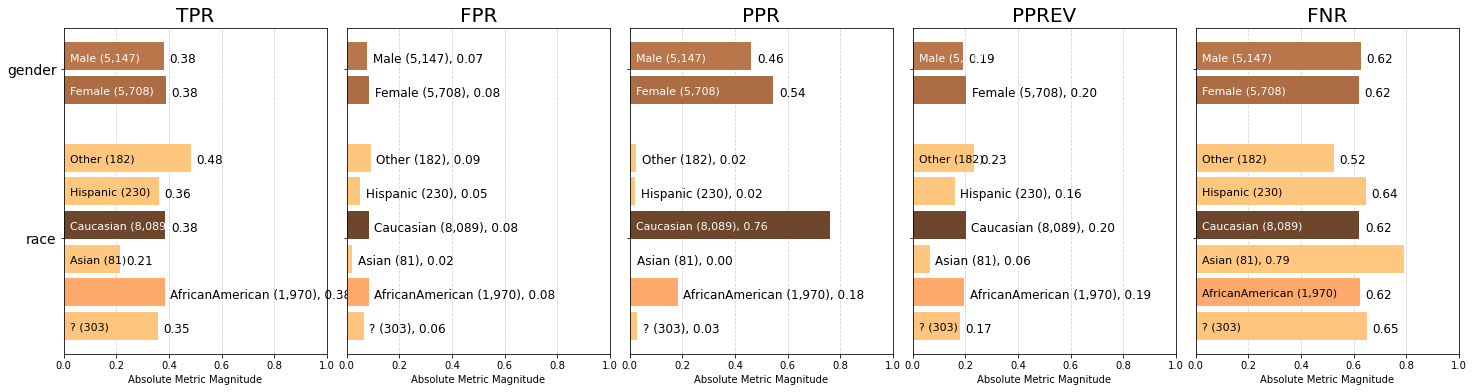

In [91]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

p = aqp.plot_group_metric_all(fdf, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5)

Gender seems fairly unbiased across all metrics.

Asians seem to have lower rates of TPR, FPR, PPR, and PPREV compared to other races, while having the highest False Negative Rate(FNR). Caucasians have a much higher PPR predicted positive rate compared to all other races. It would be best to stratify the training, validation, and test data to maintain racial proportionality and represent the intended clinical trial population.

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

I have updated the reference group selection to be ***African American, Female***.

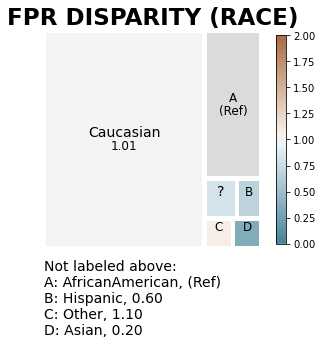

In [92]:
# Reference group fairness plot

fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='race')

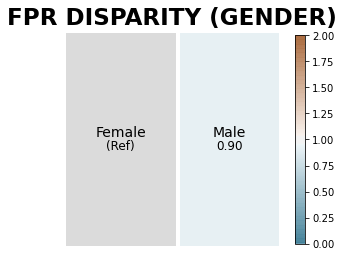

In [114]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

From the race false positive rate disparity plot, we see that African American females and Caucasian females have nearly identical false positive rates, while Hispanic females are 60% as likely to have a false positive, while Asian females are 20% as likely to have a false positive. 

From the gender disparity plot, we see that FPR rates across gender are within 10% of each other, indicating very minor disparity.

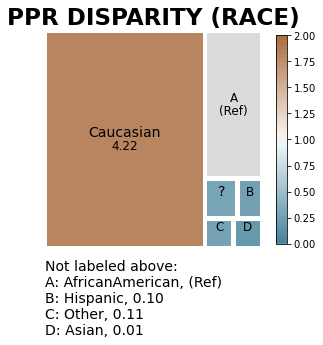

In [117]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='ppr_disparity', 
                                       attribute_name='race')

For PPR, there is significant disparity among races compared to the reference group. From the Predicted Positive Rate disparity plot, we see that when compared to African American females, Caucasian females are over 4 times as likely to have a positive prediction, while Hispanic females are 1/10 as likely and Asian females are 1/100 as likely to have a positive prediction.